<a href="https://colab.research.google.com/github/sidarthsub/COVID-Image-Recognition-Project/blob/master/CIS545Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

This project is an attempt to use chest X-Ray scans of Cononavirus patients to predict patient survival. I build a CNN to classify the training data and analyze my findings below. The data/dataloader and some of the inspiration for the questions asked by the project can be found at https://github.com/ieee8023/covid-chestxray-dataset/

# **Preprocessing**

## **Imports and Installs**

In [ ]:
!pip install mxnet
from PIL import Image
from os.path import join
from skimage.io import imread, imsave
from torch import nn
from torch.nn.modules.linear import Linear
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import numpy as np
import os,sys,os.path
import pandas as pd
import pickle
import skimage
import glob
import collections
import pprint
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms.functional as TF
import skimage.transform
import warnings
import tarfile
from mpl_toolkits.axes_grid1 import ImageGrid



## **Dataloader Class**

The following dataloader/Dataset class is provided on the github of the image dataset (https://github.com/ieee8023/covid-chestxray-dataset/). The majority of it is copied here but a number of changes are required in order for it to meet our needs. First, the labels must be changed to survived/died in order to meet our requirements. The paths of images have been drastically altered to pull directly from the github. Additionally, some syntactical changes were made in order to get the loaded data to play nice with the model

In [ ]:

default_pathologies = [  'Atelectasis',
                 'Consolidation',
                 'Infiltration',
                 'Pneumothorax',
                 'Edema',
                 'Emphysema',
                 'Fibrosis',
                 'Effusion',
                 'Pneumonia',
                 'Pleural_Thickening',
                 'Cardiomegaly',
                 'Nodule',
                 'Mass',
                 'Hernia',
                 'Lung Lesion',
                 'Fracture',
                 'Lung Opacity',
                 'Enlarged Cardiomediastinum'
                ]

thispath = 'https://github.com/ieee8023/covid-chestxray-dataset/'

def relabel_dataset(pathologies, dataset):
    """
    Reorder, remove, or add (nans) to a dataset's labels.
    Use this to align with the output of a network.
    """
    will_drop = set(dataset.pathologies).difference(pathologies)
    if will_drop != set():
        print("{} will be dropped".format(will_drop))
    new_labels = []
    dataset.pathologies = list(dataset.pathologies)
    for pathology in pathologies:
        if pathology in dataset.pathologies:
            pathology_idx = dataset.pathologies.index(pathology)
            new_labels.append(dataset.labels[:,pathology_idx])
        else:
            print("{} doesn't exist. Adding nans instead.".format(pathology))
            values = np.empty(dataset.labels.shape[0])
            values.fill(np.nan)
            new_labels.append(values)
    new_labels = np.asarray(new_labels).T
    
    dataset.labels = new_labels
    dataset.pathologies = pathologies

class Dataset():
    def __init__(self):
        pass
    def totals(self):
        counts = [dict(collections.Counter(items[~np.isnan(items)]).most_common()) for items in self.labels.T]
        return dict(zip(self.pathologies,counts))
    def check_paths_exist(self):
        if not os.path.isdir(self.imgpath):
            raise Exception("imgpath must be a directory")
        if not os.path.isfile(self.csvpath):
            raise Exception("csvpath must be a file")
        
    
class Merge_Dataset(Dataset):
    def __init__(self, datasets, seed=0, label_concat=False):
        super(Merge_Dataset, self).__init__()
        np.random.seed(seed)  # Reset the seed so all runs are the same.
        self.datasets = datasets
        self.length = 0
        self.pathologies = datasets[0].pathologies
        self.which_dataset = np.zeros(0)
        self.offset = np.zeros(0)
        currentoffset = 0
        for i, dataset in enumerate(datasets):
            self.which_dataset = np.concatenate([self.which_dataset, np.zeros(len(dataset))+i])
            self.length += len(dataset)
            self.offset = np.concatenate([self.offset, np.zeros(len(dataset))+currentoffset])
            currentoffset += len(dataset)
            if dataset.pathologies != self.pathologies:
                raise Exception("incorrect pathology alignment")
                
        if hasattr(datasets[0], 'labels'):
            self.labels = np.concatenate([d.labels for d in datasets])
        else:
            print("WARN: not adding .labels")
        
        self.which_dataset = self.which_dataset.astype(int)
        
        if label_concat:
            new_labels = np.zeros([self.labels.shape[0], self.labels.shape[1]*len(datasets)])*np.nan
            for i, shift in enumerate(self.which_dataset):
                size = self.labels.shape[1]
                new_labels[i,shift*size:shift*size+size] = self.labels[i]
            self.labels = new_labels
            
        try:
            self.csv = pd.concat([d.csv for d in datasets])
        except:
            print("Could not merge dataframes (.csv not available):", sys.exc_info()[0])
            
            
    def __repr__(self):
        pprint.pprint(self.totals())
        return self.__class__.__name__ + " num_samples={}".format(len(self))
    
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        item = self.datasets[int(self.which_dataset[idx])][idx  - int(self.offset[idx])]
        item["lab"] = self.labels[idx]
        item["source"] = self.which_dataset[idx]
        return item
        
class FilterDataset(Dataset):
    def __init__(self, dataset, labels=None):
        super(FilterDataset, self).__init__()
        self.dataset = dataset
        self.pathologies = dataset.pathologies
        
#         self.idxs = np.where(np.nansum(dataset.labels, axis=1) > 0)[0]
        
        self.idxs = []
        if labels:
            for label in labels:
                print("filtering for ", label)
                
                self.idxs += list(np.where(dataset.labels[:,list(dataset.pathologies).index(label)] == 1)[0])
#             singlelabel = np.nanargmax(dataset.labels[self.idxs], axis=1)
#             subset = [k in labels for k in singlelabel]
#             self.idxs = self.idxs[np.array(subset)]
        
        self.labels = self.dataset.labels[self.idxs]
        self.csv = self.dataset.csv.iloc[self.idxs]
                
    def __repr__(self):
        pprint.pprint(self.totals())
        return self.__class__.__name__ + " num_samples={}".format(len(self))
    
    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, idx):
        return self.dataset[self.idxs[idx]]

class SubsetDataset(Dataset):
    def __init__(self, dataset, idxs=None):
        super(SubsetDataset, self).__init__()
        self.dataset = dataset
        self.pathologies = dataset.pathologies
        
        self.idxs = idxs
        
        self.labels = self.dataset.labels[self.idxs]
        self.csv = self.dataset.csv.iloc[self.idxs]
                
    def __repr__(self):
        pprint.pprint(self.totals())
        return self.__class__.__name__ + " num_samples={}".format(len(self))
    
    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, idx):
        return self.dataset[self.idxs[idx]]

class COVID19_Dataset(Dataset):
    """
    COVID-19 image data collection
    Dataset: https://github.com/ieee8023/covid-chestxray-dataset
    
    Paper: https://arxiv.org/abs/2003.11597
    """
    
    def __init__(self, 
                 imgpath="https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/images/", 
                 csvpath="https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/metadata.csv", 
                 views=["PA"],
                 transform=None, 
                 data_aug=None, 
                 nrows=None, 
                 seed=0,
                 pure_labels=False, 
                 unique_patients=True):

        super(COVID19_Dataset, self).__init__()
        np.random.seed(seed)  # Reset the seed so all runs are the same.
        self.imgpath = imgpath
        self.transform = transform
        self.data_aug = data_aug
        self.views = views
        
        # defined here to make the code easier to read
        pneumonias = ["COVID-19", "SARS", "MERS", "ARDS", "Streptococcus", "Pneumocystis", "Klebsiella", "Chlamydophila", "Legionella"]
        
        self.pathologies = ["Pneumonia","Viral Pneumonia", "Bacterial Pneumonia", "Fungal Pneumonia", "No Finding"] + pneumonias
        self.pathologies = sorted(self.pathologies)

        mapping = dict()
        mapping["Pneumonia"] = pneumonias
        mapping["Viral Pneumonia"] = ["COVID-19", "SARS", "MERS"]
        mapping["Bacterial Pneumonia"] = ["Streptococcus", "Klebsiella", "Chlamydophila", "Legionella"]
        mapping["Fungal Pneumonia"] = ["Pneumocystis"]
        
        # Load data
        self.csvpath = csvpath
        self.csv = pd.read_csv(self.csvpath, nrows=nrows)
        self.MAXVAL = 255  # Range [0 255]

        # Keep only the frontal views.
        #idx_pa = self.csv["view"].isin(["PA", "AP", "AP Supine"])
        idx_pa = self.csv["view"].isin(self.views)
        self.csv = self.csv[idx_pa]
        self.csv = self.csv[self.csv['survival'].notnull()]

        
        self.labels = self.csv['survival'].apply(lambda x: 0 if x == 'N' else 1 if x=='Y' else 66)
        #for pathology in self.pathologies:
        #    mask = self.csv["finding"].str.contains(pathology)
        #    if pathology in mapping:
        #        for syn in mapping[pathology]:
        #            #print("mapping", syn)
        #            mask |= self.csv["finding"].str.contains(syn)
        #    self.labels.append(mask.values)
        self.labels = torch.Tensor(self.labels).type(torch.FloatTensor)
        #self.labels = self.labels.astype(np.float32)

    def __repr__(self):
        pprint.pprint(self.totals())
        return self.__class__.__name__ + " num_samples={} views={}".format(len(self), self.views)
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        imgid = self.csv['filename'].iloc[idx]
        img_path = self.imgpath + imgid
        img = imread(img_path)
        img = np.array(img)
        # Check that images are 2D arrays
        if len(img.shape) > 2:
            img = img[:, :, 0]
        if len(img.shape) < 2:
            print("error, dimension lower than 2 for image")

        # Add color channel
        img = img[None, :, :]                    
                               
        if self.transform is not None:
            img = self.transform(img)

        if self.data_aug is not None:
            img = self.data_aug(img)
            
        return (img, self.labels[idx]) #{"img":img, "lab":self.labels[idx], "idx":idx}
class ToPILImage(object):
    def __init__(self):
        self.to_pil = transforms.ToPILImage(mode="L")

    def __call__(self, x):
        return(self.to_pil(x[0]))


## **EDA**

Lets look at the images as a sanity check - we want to make sure they make sense and are correctly loaded in. But, before we do that, its important to note that many of the images in the github do not have tags as to whether a patient lived or died. This perhaps represents patients currently fighting the virus or simply poor record keeping and is thus excluded as we can neither train nor verify on it.

Additionally, this data includes some patients from prior SARS outbreaks. As coronavirus is a type of SARS, these images have been retained in order to have a reasonable amount to train on. As a result, the model is really a predictor of ones survival with SARS, not just SARS-COV-2 (which causes COVID-19)

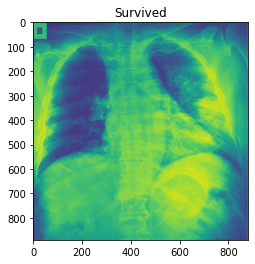

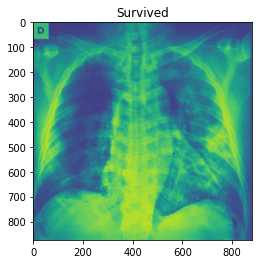

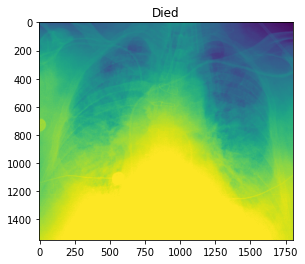

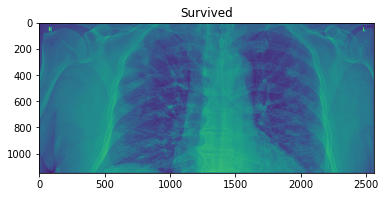

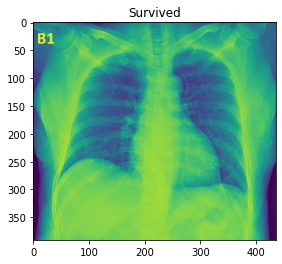

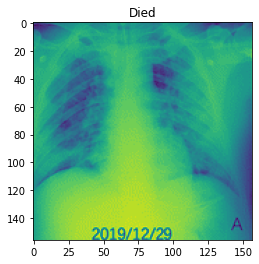

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
visData = COVID19_Dataset()
sample_idxs = [1, 3, 6, 12, 34, 57]
for sample_idx in sample_idxs:
    data, label = visData[sample_idx]
    plt.imshow(data[0])
    if (label):
      plt.title('Survived')
    else:
      plt.title('Died')
    plt.show()

Some of these images are massive and they are all different sizes. This is a problem - what if we resized all of them and cropped out so only the center was visible?

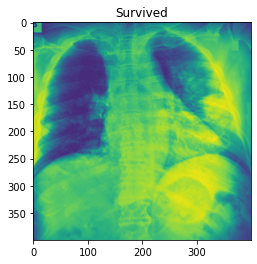

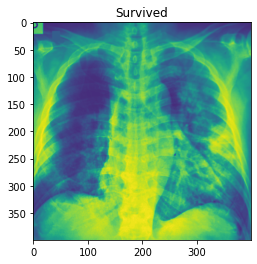

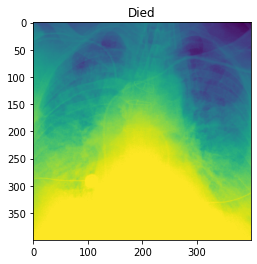

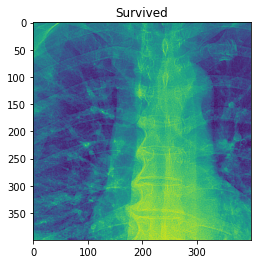

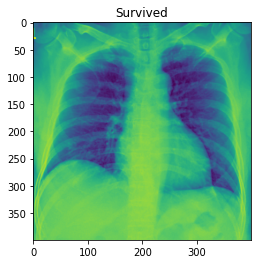

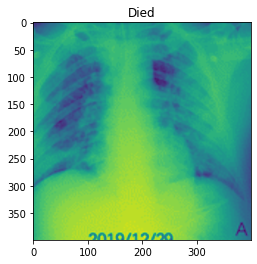

In [ ]:
topil = ToPILImage()
transformations = transforms.Compose([topil,
                                                          transforms.Resize(size = 422), 
                                                          transforms.CenterCrop(400)])

visData = COVID19_Dataset(transform=transformations)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sample_idxs = [1, 3, 6, 12, 34, 57]
for sample_idx in sample_idxs:
    data, label = visData[sample_idx]
    #display(data)
    plt.imshow(np.asarray(data))
    if (label):
      plt.title('Survived')
    else:
      plt.title('Died')
    plt.show()

Those images look good - they still have the main features of the model (the lungs) and are much more evenly and reasonably sized. Now lets look a bit more at the data and see if it makes sense

First, lets just take a cursory glance at the scans of deceased patients and see if there are any patterns

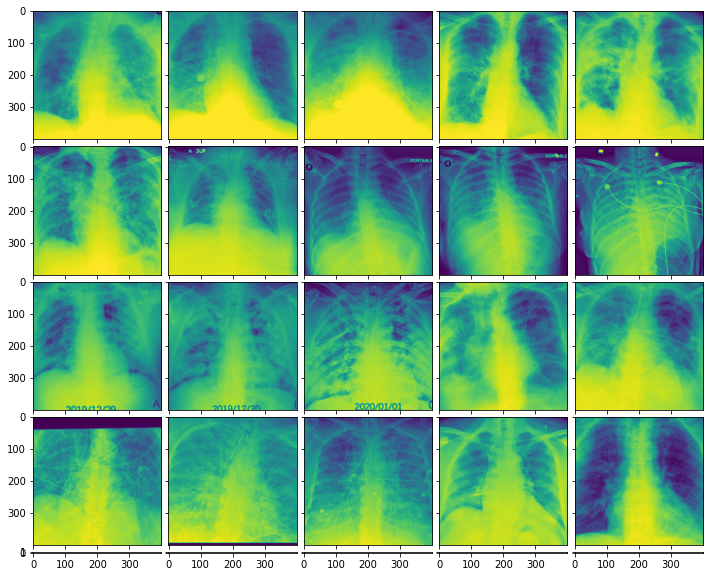

In [ ]:
fig = plt.figure(figsize=(12., 12.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

imlist = []
for sample_idx in range(len(visData)):
    data, label = visData[sample_idx]
    #display(data)
    if (label == 0):
      imlist.append(np.asarray(data))
for ax, im in zip(grid, imlist):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.title('Scans of Dead Patients')
plt.show()


I'm not a doctor so I have a very limited medical perspective on the data but on intial inspection, it seems like the lungs are generally fairly cloudy. Lets plot the survivors and see if we can notice any differences 

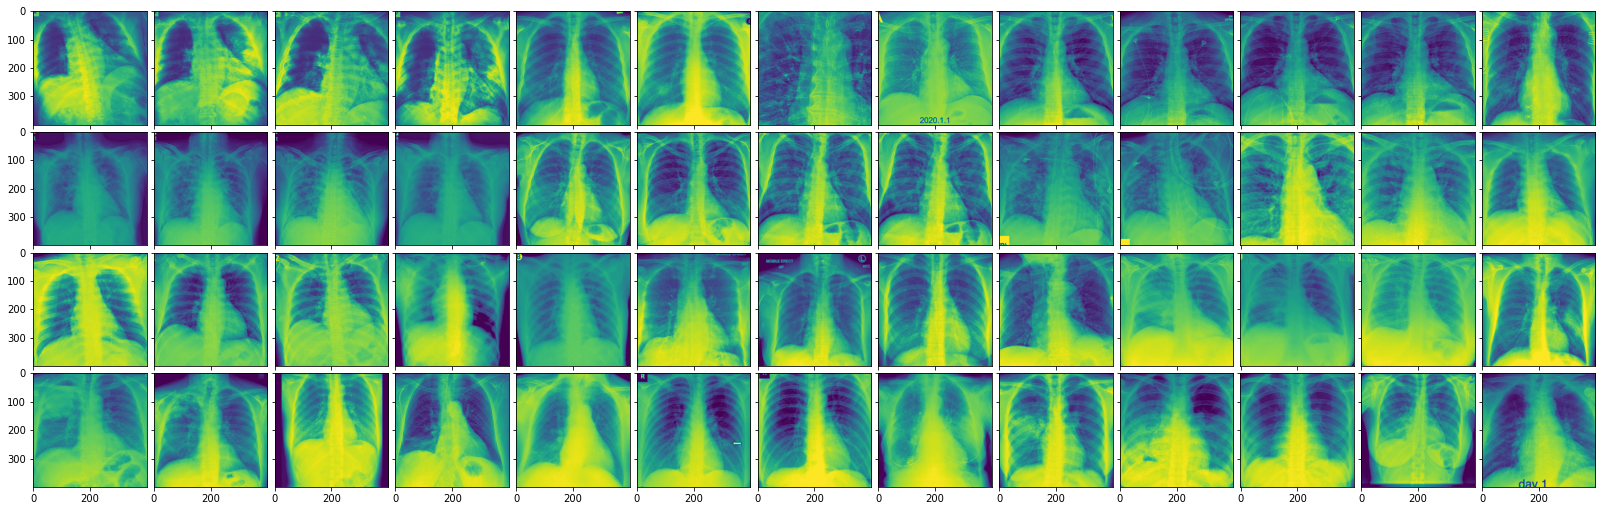

In [ ]:
fig = plt.figure(figsize=(28., 28.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 13),  # creates 13x4 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

imlist = []
for sample_idx in range(len(visData)):
    data, label = visData[sample_idx]
    #display(data)
    if (label == 1):
      imlist.append(np.asarray(data))
for ax, im in zip(grid, imlist):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.title('Scans of Alive Patients')
plt.show()


Now some clear differences start to appear. A number of them have fewer 'clouds' in the lungs. Additionally the bottoms of the survived images seem to be noticably less bright than those of the deceased. Its not clear to me what these represent medically but hopefully the model will pick up on these differences.

Its important to note that there are a number of differences even between the survived images. Conv NNs have translational invariance and are fairly adept at parsing these differences so hopefully the model will still be successful given the varities in images. Substantial further analysis is challenging as images are hard to work with - thats where the NN comes in

## **Splitting and preprocessing the data**

 Now that we have got a sense for what the data looks like, we have to split it into training and validation sets and preprocess the data in order to input it into our model.

In [ ]:
from torch.utils.data import SubsetRandomSampler
valsplit = .4
batch_size = 8
random_seed = 0
#defines some parameters (like size of the validation dataset) for splitting/preprocessing
topil = ToPILImage()

transformations = transforms.Compose([topil,
                                        transforms.Resize(size = 422), 
                                        transforms.CenterCrop(400),
                                        transforms.ToTensor()])
# the above transformations ensure that the data is in the right format for the neural net and is of a small enough size as to not crash colab
Dataset = COVID19_Dataset(seed = random_seed, transform=transformations)
size = len(Dataset)
indices = list(range(size))
split = int(np.floor(valsplit * size))
np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split] ##We calculate a random subset of indecies to split the data into train and test data for validation purposes

trainsubset = SubsetDataset(Dataset, train_indices)
testsubset = SubsetDataset(Dataset, test_indices)

## **Balancing and loading the data**

However, we are in trouble - around 70% of our data is from patients who survived. If we pass this as is to the model, it will be able to predict with 70% accuracy simply by claiming everyone survived. This will dramatically reduce the predictive power of the model. As a result, we balance the dataset by weighting the samples so that there are a roughly equivalent number of dead and alive scans in the train data.

In [ ]:
def make_weights_for_balanced_classes(labels):                        
    x = [z.numpy() for z in labels]
    x = np.concatenate( x, axis=0 )
    x = [0 if z == -1 else z for z in x]
    num_survived = np.sum(x) 
    totalnum = len(x)
    print("The proportion of survived of our train dataset is: " + str(100*num_survived/totalnum))
    weights = [(totalnum - num_survived)/(totalnum) if z else (num_survived)/totalnum for z in x]
    return weights                                               


In [ ]:
train_loaderw = torch.utils.data.DataLoader(trainsubset, batch_size=batch_size)
imagelist = []
for data, labels in train_loaderw:
  imagelist.append(labels)
weights = make_weights_for_balanced_classes(imagelist)


The proportion of survived of our train dataset is: 70.45454545454545


Its time to put all our data into a dataloader - this will allow the model to learn in batches.

In [ ]:
#The proportion survived is way too high! luckily, we just computed the weights and can account for this
sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))
#This reweights the data using WeightedRandomSampler and loads it into a dataloader
train_loader = torch.utils.data.DataLoader(trainsubset, batch_size=batch_size, sampler = sampler)
test_loader = torch.utils.data.DataLoader(testsubset, batch_size=1)


# **The Model**

## **Defining the model and hyperparameters**

Now its time to actually build and train the neural net. Convolutional NNs are especially useful for image classification and as such we will first apply a number of convolutional layers prior to the dense linear ones. The model is defined and then a main train loop handles calculation of loss and backpropagation. Lastly we verify accuracy on the validation set.

In [ ]:
class Args(object):
  pass

args = Args();
args.learning_rate = .00001
args.log_interval = 2
args.num_epochs =25
args.epoch = 1
# All the hyperparameters are stored in args, which is passed to the training loop 

In [ ]:
class CNNClassifier(torch.nn.Module):
    def __init__(self):
      super(CNNClassifier, self).__init__()
      self.conv1 = nn.Conv2d(1, 96, 2, 3)
      self.conv2 = nn.Conv2d(96, 128, 2, 1)
      self.conv3 = nn.Conv2d(128, 256, 2, 1)
      self.drop1 = nn.Dropout2d(.25)
      self.drop2 = nn.Dropout2d(.5)
      self.fc1 = nn.Linear(262144, 1024)  # 262144 from image dimension
      self.fc2 = nn.Linear(1024, 1024)  
      self.fc3 = nn.Linear(1024, 1)   #predicts a binary output of yes or no for survival

    def forward(self, x):
      x = F.relu(F.max_pool2d(self.conv1(x), 2))
      x = F.relu(self.conv2(x))
      x = F.relu(F.max_pool2d(self.conv3(x), 2))
      x = self.drop1(x)
      x = torch.flatten(x, 1)
      x = self.drop1(x)
      x = self.fc1(x)
      x = self.drop1(x)
      x = self.fc2(x)
      x = self.drop2(x)
      x = self.fc3(x)
      output = x
      return output


## **Main Training Loop**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
def train(args):
    ### This is the main training loop
    
    n_epochs = args.epoch
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):

      ##Computes the loss and does the relevant backpropogation through the optimizer
      optimizer.zero_grad()
      output = model(data)
      temp = torch.nn.BCEWithLogitsLoss()
      output = output.reshape(-1)
      loss=temp.forward(output, target)
      loss.backward()
      g = loss.item()
      optimizer.step()

      ##Logs losses per batch in the epoch depending on the log interval
      if batch_idx % args.log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          n_epochs, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), g))
        train_losses.append(g)
        train_counter.append(
          (batch_idx*64) + ((n_epochs-1)*len(train_loader.dataset)))


## **Test Function**

In [ ]:
# This function computes the accuracy on the validation data set to determine how the model is performing
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = torch.sigmoid(model(data)).reshape(-1)
      pred = torch.round(output)
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
  correct, len(test_loader.dataset),
  100. * correct / len(test_loader.dataset)))
  return 100. * correct / len(test_loader.dataset)

In [ ]:
train_losses = []
accuracy = []
train_counter = []
test_counter = [i*len(train_loader.dataset) for i in range(args.num_epochs + 1)]
num_steps_per_epoch = len([i for i in range(len(train_loader)) if i%args.log_interval==0])
model = CNNClassifier()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
optimizer.zero_grad()
for i in range(args.num_epochs):
  args.epoch = i+1
  train(args)
  a = test()
  accuracy.append(a)
  print(a)
  if (a > 86):
    print('Done!')
    break


Train Epoch: 1 [0/44 (0%)]	Loss: 0.694268
Train Epoch: 1 [16/44 (33%)]	Loss: 0.700320
Train Epoch: 1 [32/44 (67%)]	Loss: 0.684408

Test set: Accuracy: 22/28 (79%)

tensor(78.5714)
Train Epoch: 2 [0/44 (0%)]	Loss: 0.653334
Train Epoch: 2 [16/44 (33%)]	Loss: 0.687484
Train Epoch: 2 [32/44 (67%)]	Loss: 0.628856

Test set: Accuracy: 21/28 (75%)

tensor(75.)
Train Epoch: 3 [0/44 (0%)]	Loss: 0.712298
Train Epoch: 3 [16/44 (33%)]	Loss: 0.549429
Train Epoch: 3 [32/44 (67%)]	Loss: 0.687275

Test set: Accuracy: 21/28 (75%)

tensor(75.)
Train Epoch: 4 [0/44 (0%)]	Loss: 0.548657
Train Epoch: 4 [16/44 (33%)]	Loss: 0.604357
Train Epoch: 4 [32/44 (67%)]	Loss: 0.765967

Test set: Accuracy: 21/28 (75%)

tensor(75.)
Train Epoch: 5 [0/44 (0%)]	Loss: 0.616534
Train Epoch: 5 [16/44 (33%)]	Loss: 0.752159
Train Epoch: 5 [32/44 (67%)]	Loss: 0.549143

Test set: Accuracy: 10/28 (36%)

tensor(35.7143)
Train Epoch: 6 [0/44 (0%)]	Loss: 0.573858
Train Epoch: 6 [16/44 (33%)]	Loss: 0.778960
Train Epoch: 6 [32/44 (67%

# **Analysis**

## **Results/Visualization**

How did we do? the model was able to achieve a validation accuracy of 86% on the test set. This is quite good! But lets visualize a few things to make it clear how training/validation is going. First, lets visualize the training loss calculated at each log interval (3 times per epoch)

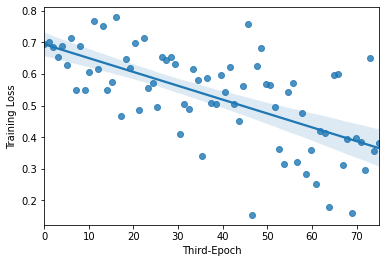

In [ ]:
import seaborn as sns

toplot = pd.DataFrame()
toplot['Training Loss'] = train_losses
toplot['Third-Epoch'] = np.linspace(0, len(train_losses), len(train_losses))
sns.regplot(x='Third-Epoch',y='Training Loss',data = toplot, fit_reg=True)


Clearly the model is learning as training loss trends downward - the loss is a bit chaotic however. This isn't surprising given what I observed with accuracy. Slight changes in the model would drastically affect its performance and thus loss. Additionally, these losses were computed every other batch so the model only saw 16 datapoints between losses, leading to the chaotic graph above. Nevertheless, the trend is good! Now lets try validation accuracy per epoch

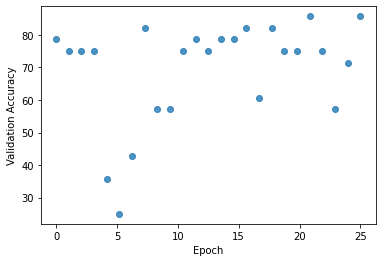

In [ ]:
toplot = pd.DataFrame()
acc = np.array([z.numpy().astype(float) for z in accuracy], dtype=float)
toplot['Validation Accuracy'] = acc
toplot['Epoch'] = np.linspace(0, len(acc), len(acc))
sns.regplot(x='Epoch',y='Validation Accuracy',data = toplot, fit_reg=False)


This is a bit less encouraging at first glance. However, recall the discussion regarding the overabundance of survival scans. This was resolved in the train data but the test data is (correctly) unaltered. But, the model, initially, by chance predicts almost all survived. Since there are few distinctions between weights, it is unsurprising that most of the model's predictions are similar in the beginning. This allows it to achieve a decent accuracy of around 71% (if it predicts all survived) despite a high loss (its unsure about its predicitons). Thus the first 4 datapoints are removed and we get the following graph.

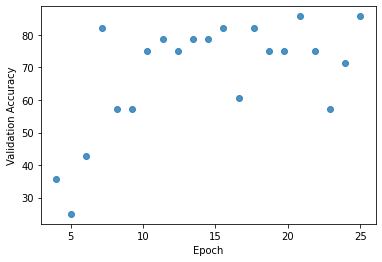

In [ ]:
toplot = pd.DataFrame()
acc = np.array([z.numpy().astype(float) for z in accuracy], dtype=float)
acc = acc[4:]
toplot['Validation Accuracy'] = acc
toplot['Epoch'] = np.linspace(4, len(acc)+4, len(acc))
sns.regplot(x='Epoch',y='Validation Accuracy',data = toplot, fit_reg=False)

Thats more like it! Lets visualize exactly which predicitons the model goes wrong on.

In [ ]:
predlist = []
datalist = []
outputlist = []
targetlist = []
correct = 0
for data, target in test_loader:
      datalist.append(data.numpy())
      targetlist.append(target.numpy())
      output = torch.sigmoid(model(data)).reshape(-1)
      outputlist.append(output.detach().numpy())
      predlist.append(torch.round(output).detach().numpy())
outputlist = np.vstack(outputlist).reshape(-1)
predictions = np.vstack(predlist).reshape(-1)
datalist = np.vstack(datalist)
targetlist = np.vstack(targetlist).reshape(-1)

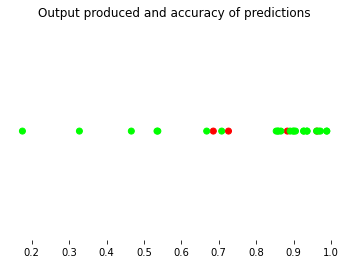

In [ ]:
dataframe = pd.DataFrame()
dataframe['Output'] = outputlist
dataframe['Predicted'] = predictions
dataframe['Actual'] = targetlist
dataframe['Is Correct'] = predictions == targetlist

colors = ["#00FF00" if z else '#FF0000' for z in dataframe['Is Correct']]
ax1 = plt.axes(frameon=False)
ax1.axes.get_yaxis().set_visible(False)
plt.scatter(outputlist, np.zeros_like(outputlist), color = colors)
plt.title('Output produced and accuracy of predictions')
plt.show()


This is a bit confusing to interpret - basically the x axis represents the output of the sigmoid function at the end of the model. A value close to 1 indicates survival and a value far from it indicates death. As a result, we would expect the values closest to .5 to be the most problematic. None of the extreme values are misclassified by the model. Nevertheless most of the errors lie around .7 rather than .5. This isn't too far off and indicates that the model is (for the most part) working as intended. Additionally, all of these are false survivals - the model is probably a bit too optimistic.

## **Challenges**

The model was challenging to create and tune. First, the size of the images quickly used up the available RAM in colab if a number of substantial linear layers were included. The in-size of the first linear layer was nearly 300 thousand, which quickly led to issues. Additionally, the model was extremely sensitive to small changes in weights and thus the learning rate had to be finely tuned to balance performance and accuracy

Additionally, the images themselves (and the provided dataloader) needed a fair bit of preprocessing to work viably.

Despite these challenges, the model was very succesful (86% accuracy!)